In [ ]:
# Welcome to the Colab Demo of Group N3 - Generating Faces using a conditional Generative Adversial Network

# Imports

In [51]:
# Imports

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from google.colab import drive
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU, BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [24]:
import warnings
warnings.filterwarnings("ignore")

# Function definitions to make the notebook more readable

In [69]:
# define the standalone generator model
def define_cond_generator(latent_dim, n_classes=40):

    # label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 8*8*1
    li = Dense(n_nodes)(li)
    li = Reshape((8, 8, 1), name="Cond_G_Reshape_2")(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))

    n_nodes = 3*8*8    # since 3 channels
    gen = Dense(n_nodes)(in_lat)
    gen = ReLU()(gen)
    gen = Reshape((8, 8, 3), name="Cond_G_Reshape_3")(gen)

    merge = Concatenate()([gen, li])
    
    # 16x16
    gen = Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same')(merge)
    gen = ReLU()(gen)
    
    # 32x32
    gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    
    # 64x64
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    
    # 128x128
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)

    # 1X1 conv, reduce channels to 3 - rgb
    out_layer = Conv2D(3, (7, 7), activation='tanh', padding='same')(gen)  # or 128, 128

    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_cond_gan(g_model, d_model):

    # Use this model to ONLY train generator
    d_model.trainable = False

    gen_noise, gen_label = g_model.input
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# define the standalone discriminator model
def define_cond_discriminator(in_shape=(128,128,3), n_classes=40):

    # label input
    in_label = Input(shape = (1,), name = "Input_Label")
    li = Embedding( n_classes , 50, name="Embedding_D")(in_label)

    n_nodes = in_shape[0] * in_shape[1] * 1 # 128*128*1
    li = Dense(n_nodes, name="Cond_D_Dense_1")(li)
    li = Reshape((in_shape[0], in_shape[1], 1), name="Cond_D_Reshape_1")(li)

    # image input
    in_image = Input(shape=in_shape, name="Cond_D_Input_Image")

    # concat label as a channel
    merge = Concatenate(name="Cond_D_Concatenate_1")([in_image, li])

    fe = Conv2D(64, (3,3), strides=(2,2), padding='same', name="Cond_D_Conv_1")(merge)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_1")(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_2")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_2")(fe)

    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_3")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_3")(fe)

    fe = Conv2D(512, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_4")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_4")(fe)
    
    fe = Flatten(name="Cond_D_Flatten_1")(fe)
    fe = Dropout(0.3, name="Cond_D_Dropout_1")(fe)

    out_layer = Dense(1, activation='sigmoid', name="Cond_D_Dense_2")(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=40):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples, n_class=0):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    labels_input = np.array([n_class]*z_input.shape[0])
    # predict outputs
    #print(f"SAFE. z_input: {z_input.shape}, labels_input:{labels_input.shape}")
    images = generator.predict([z_input, labels_input])
    #print(images.shape)
    # create class labels

    return images, labels_input

def plot_fakes_complex(generator, latent_dim):
    X_eye, _ = generate_fake_samples(generator, latent_dim, 5, n_class=0)
    X_cheeks,_ = generate_fake_samples(generator, latent_dim, 5, n_class=1)
    X_goatee,_ = generate_fake_samples(generator, latent_dim, 5, n_class=2)

    #print(X_eye.shape, X_cheeks.shape, X_goatee.shape)
    X = np.concatenate([X_eye, X_cheeks, X_goatee], axis=0)
    class_header = ["Eyeglasses", "Rosy Cheeks", "Goatee"]
    fig, rows = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
    i=0
    j=0
    for row in rows:
        for ax in row:
            ax.imshow(((X[i]+1)*127.5).astype("uint8"))
            ax.set_title(f"{class_header[j]}")
            ax.axis("off")
            i=i+1
        j=j+1
    plt.tight_layout()
    plt.show()

In [150]:
# define the standalone discriminator model
def define_weak_discriminator():
    """
    define_cond_discriminator: This function defines the architecture of the discriminator model, where we 
                               transformed the labels of attributes into the same shape dimension as image 
                               using embedding layers. And the labels are concatenated with the image 
                               as a channel. The model has 3 layers of convolutional neural networks with 
                               same numbers of filters.

    Arguments:
        args:   Parser which contains all the variables and paths.

    Returns:
        model:  It returns the architecture of the model.
    """

    n_classes = 40
    in_shape = (128, 128, 3)

    # label input
    in_label = Input(shape = (1,), name = "Input_Label")
    li = Embedding( n_classes , 50, name="Embedding_D")(in_label)

    n_nodes = in_shape[0] * in_shape[1] * 1 # 128*128*1
    li = Dense(n_nodes, name="Cond_D_Dense_1")(li)
    li = Reshape((in_shape[0], in_shape[1], 1), name="Cond_D_Reshape_1")(li)

    # image input
    in_image = Input(shape=in_shape, name="Cond_D_Input_Image")

    # concat label as a channel
    merge = Concatenate(name="Cond_D_Concatenate_1")([in_image, li])

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name="Cond_D_Conv_1")(merge)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_1")(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_2")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_2")(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_3")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_3")(fe)

    fe = Flatten(name="Cond_D_Flatten_1")(fe)
    fe = Dropout(0.4, name="Cond_D_Dropout_1")(fe)

    out_layer = Dense(1, activation='sigmoid', name="Cond_D_Dense_2")(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_weak_generator(latent_dim):
    """
    define_cond_generator: This function defines the architecture of the generator model, where we 
                          transformed the labels of attributes into the same shape dimension as image 
                          using embedding layers. And the labels are concatenated with the image 
                          as a channel. The model has 5 layers of convolutional neural networks with 
                          decreasing numbers of filters. The generator function is not trained alone, 
                          but with discriminator function.

    Arguments:
        latent_dim:  Array of random input noise of length = 100.
        args:        Parser which contains all the variables and paths.

    Returns:
        model:       It returns the architecture of the model.

    """
    n_classes = 40

    # label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 4*4*1
    li = Dense(n_nodes)(li)
    li = Reshape((4, 4, 1), name="Cond_G_Reshape_2")(li)
  
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    n_nodes = 3*4*4    # since 3 channels
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 3), name="Cond_G_Reshape_3")(gen)

    merge = Concatenate()([gen, li])
    # 4X4 to 8X8
    gen = Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # 8X8 to 16X16
    gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # 16X16 to 32X32
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # 32X32 to 64X64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # 64X64 to 128X128
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # 1X1 conv
    out_layer = Conv2D(3, (4,4), activation='tanh', padding='same')(gen)  # or 128, 128, 3

    model = Model([in_lat, in_label], out_layer)
    return model

# generate points in latent space for saving progress
def generate_latent_points_fix(latent_dim, n_classes=40):
    # generate points in the latent space
    x_input = randn(latent_dim * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_classes, latent_dim)
    # generate labels
    labels = np.array(list(range(n_classes)))
    return z_input, labels

def plot_fakes_shallow(generator, latent_dim):
    X, y = generate_latent_points_fix(latent_dim, n_classes=40)
    #print(X.shape)
    X = generator.predict([X, y])
    fig, rows = plt.subplots(nrows=8, ncols=5, figsize=(15,21))
    i=0
    for row in rows:
        for ax in row:
            ax.imshow(((X[i]+1)*127.5).astype("uint8"))
            ax.set_title(f"{CLASS_HEADER[y[i]]}")
            ax.axis("off")
            i=i+1
    plt.tight_layout()
    plt.show()

def visualize_loss(loss_csv_path):
    training_log = pd.read_csv(loss_csv_path, delimiter=";")
    fig = plt.figure(figsize=(15,7))
    plt.grid()
    plt.plot(training_log[" d_loss_real"], c="#900d0d", label="D loss real", linewidth=3, alpha=0.85)
    plt.plot(training_log[" d_loss_fake"], c="#cf1b1b", label="D loss fake", linewidth=3, alpha=0.85)
    plt.plot(training_log[" g_loss"], c="#206a5d", label="G loss", linewidth=3, alpha=0.85)
    plt.legend()
    plt.title("Losses over Epochs (Binary Cross Entropy)")
    plt.xticks([0,10,20,30,40,50,60,70,80,90,95])
    plt.show()

def visualize_loss2(loss_csv_path):
    training_log = pd.read_csv(loss_csv_path, delimiter=",")
    fig = plt.figure(figsize=(15,7))
    plt.grid()
    plt.plot(training_log[" d_loss_real"], c="#900d0d", label="D loss real", linewidth=3, alpha=0.85)
    plt.plot(training_log[" d_loss_fake"], c="#cf1b1b", label="D loss fake", linewidth=3, alpha=0.85)
    plt.plot(training_log[" g_loss"], c="#206a5d", label="G loss", linewidth=3, alpha=0.85)
    plt.legend()
    plt.title("Losses over Epochs (Binary Cross Entropy)")
    plt.show()

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    #print(vectors)
    return np.stack(vectors)

def latent_interpolations(g_model):
    
    # generate points in latent space
    n = 6
    pts = generate_latent_points(100, n)

    # interpolate pairs
    results = None
    class_label = 0
    for i in range(0, n, 2):
        # interpolate points in latent space
        interpolated = interpolate_points(pts[0][i], pts[0][i+1])
        # generate images
        X = g_model.predict([interpolated, np.ones((10,))*class_label])
        class_label = class_label + 1
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        if results is None:
            results = X
        else:
            results = np.vstack((results, X))
    # plot the result
    #plot_generated(results, 10)

    fig, rows = plt.subplots(nrows=3, ncols=10, figsize=(25,7))
    i = 0
    for row in rows:
        for ax in row:
            ax.imshow(results[i])
            ax.axis("off")
            i=i+1

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()
    #plt.suptitle("Latent Space Interpolation for Glasses, Rosy Cheeks and Goatee")
    plt.show()
    #plt.savefig(os.path.join(path, f"latent_space_interpolation_{np.random.randint(0,999999)}.png"), dpi=300)
    plt.close(fig=fig)

def plot_random_with_discr(d_model, g_model, epoch, latent_dim=100, class_header=CLASS_HEADER):
    z, label = generate_latent_points_fix(latent_dim, n_classes=3)
    predd = g_model.predict([z, label])
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
    gen_imgs = g_model.predict([z,label])
    d_pred = d_model.predict([predd,label])
    
    for ax in axes:
        ax.imshow(gen_imgs[i] * 0.5 + 0.5)
        ax.set_title(f"{class_header[i]}: {np.round(d_pred[i][0]*100, decimals=2)}%")
        i=i+1

        ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Epoch {epoch} - Descriminator probabilities of being a real image")
    plt.show()

def plot_real_with_discr(d_model,X,y, epoch, latent_dim=100, class_header=CLASS_HEADER):
    
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
    X_real = np.concatenate([X[15].reshape((1,128,128,3)).astype("float32"), X[29].reshape((1,128,128,3)).astype("float32"), X[16].reshape((1,128,128,3)).astype("float32")])
    y_real = np.array([0,1,2]).reshape((3,1))

    d_pred = d_model.predict([X_real,y_real])
    
    for ax in axes:
        ax.imshow(X_real[i] * 0.5 + 0.5)
        ax.set_title(f"{class_header[i]}: {np.round(d_pred[i][0]*100, decimals=2)}%")
        i=i+1

        ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Epoch {epoch} - Descriminator probabilities of being a real image on actual real images")
    plt.show()

# Data Loading

In [78]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [79]:
FACEDATADIR = "/content/drive/My Drive/Facedata"

In [83]:
df = pd.read_csv(os.path.join(FACEDATADIR,"list_attr_celeba_2.csv"), delimiter=";")
CLASS_HEADER = list(df.columns)[1:]

In [5]:
# The CSV to the image data
df.head()

filename  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [15]:
# Load the Data - only 2 examples per class

X = np.load(os.path.join(FACEDATADIR, f"categorical/training_data_128_128_5_o_Clock_Shadow_750.npy"))[:2]

y = np.array([0]*2)
ii=1
for klasse in CLASS_HEADER[1:]:
    X = np.concatenate([X, np.load(os.path.join(FACEDATADIR, f"categorical/training_data_128_128_{klasse}_750.npy"))[:2]])
    y = np.concatenate([y, np.array([ii]*2)])
    ii=ii+1

In [17]:
print(f"Note that this is only a subset of size: \nX: {X.shape}\ny: {y.shape}")

Note that this is only a subset of size: 
X: (80, 128, 128, 3)
y: (80,)


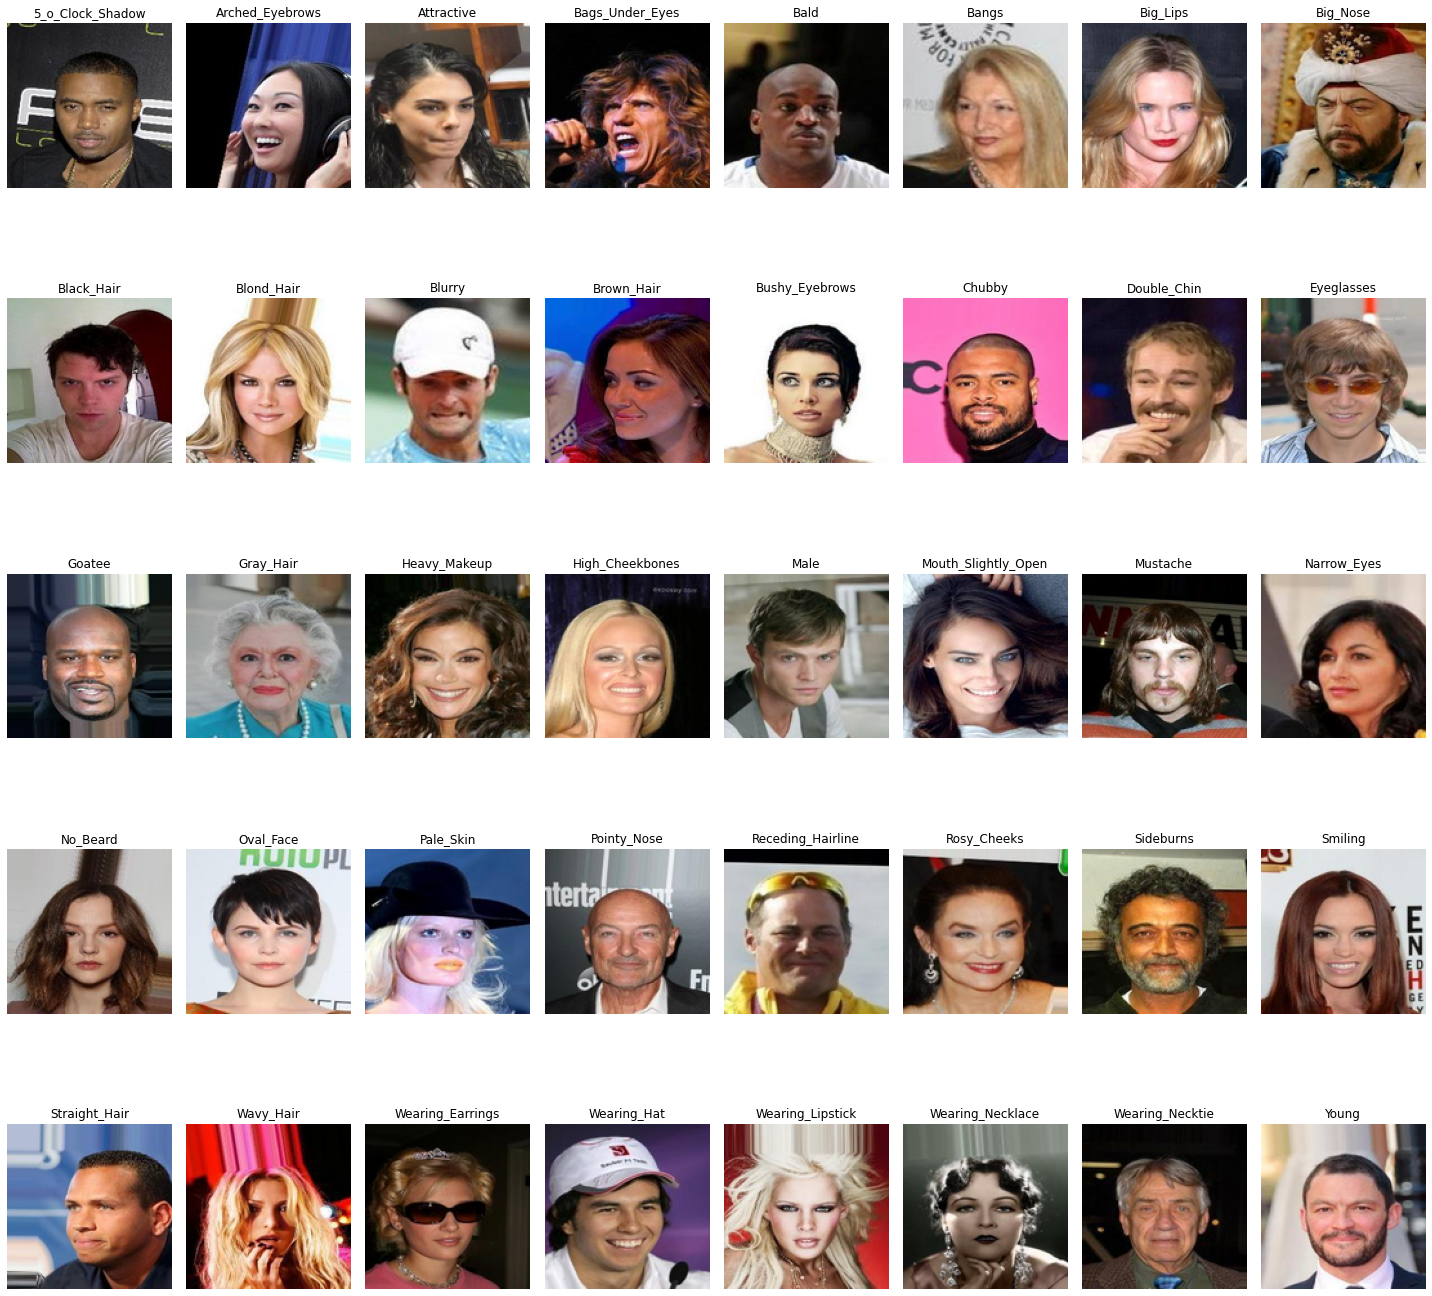

In [32]:
# Plot Training Data Subset

fig, rows = plt.subplots(nrows=5, ncols=8, figsize=(20,20))
i=0
for row in rows:
    for ax in row:
        ax.imshow(((X[i]+1)*127.5).astype("uint8"))
        ax.set_title(f"{CLASS_HEADER[i//2]}")
        ax.axis("off")
        i=i+2
plt.tight_layout()
plt.show()


# Loading the model

## Model (complex model) for the subset of three classes with 12k examples training data each class

In [53]:
latent_dim = 100
d_model = define_cond_discriminator()
g_model = define_cond_generator(latent_dim)

In [54]:
epoch = 95
CHECKPOINTS = os.path.join(FACEDATADIR, "checkpoints")
d_model.load_weights(os.path.join(CHECKPOINTS,f"final_cgan_discriminator_epoch_{epoch}.h5"))
g_model.load_weights(os.path.join(CHECKPOINTS,f"final_cgan_generator_epoch_{epoch}.h5"))

## Model (shallow model) for the full set of classes with 1000 examples per class

In [116]:
d_model_40 = define_weak_discriminator()
g_model_40 = define_weak_generator(latent_dim)

In [118]:
epoch = 190
d_model_40.load_weights(os.path.join(CHECKPOINTS,f"cgan_discriminator_{epoch}.h5"))
g_model_40.load_weights(os.path.join(CHECKPOINTS,f"cgan_generator_{epoch}.h5"))

# Visual results

## Results for the complex model (95 epochs trained)
This model was trained on nearly the full available data for the three classes "Goatee", "Eyeglasses" and "Rosy Cheeks". Even though some generated pictures do not look as impressive, we would argue that the quality on average is pretty good when taking into account that this model has only ever seen 36,000 different images for only 95 epochs.

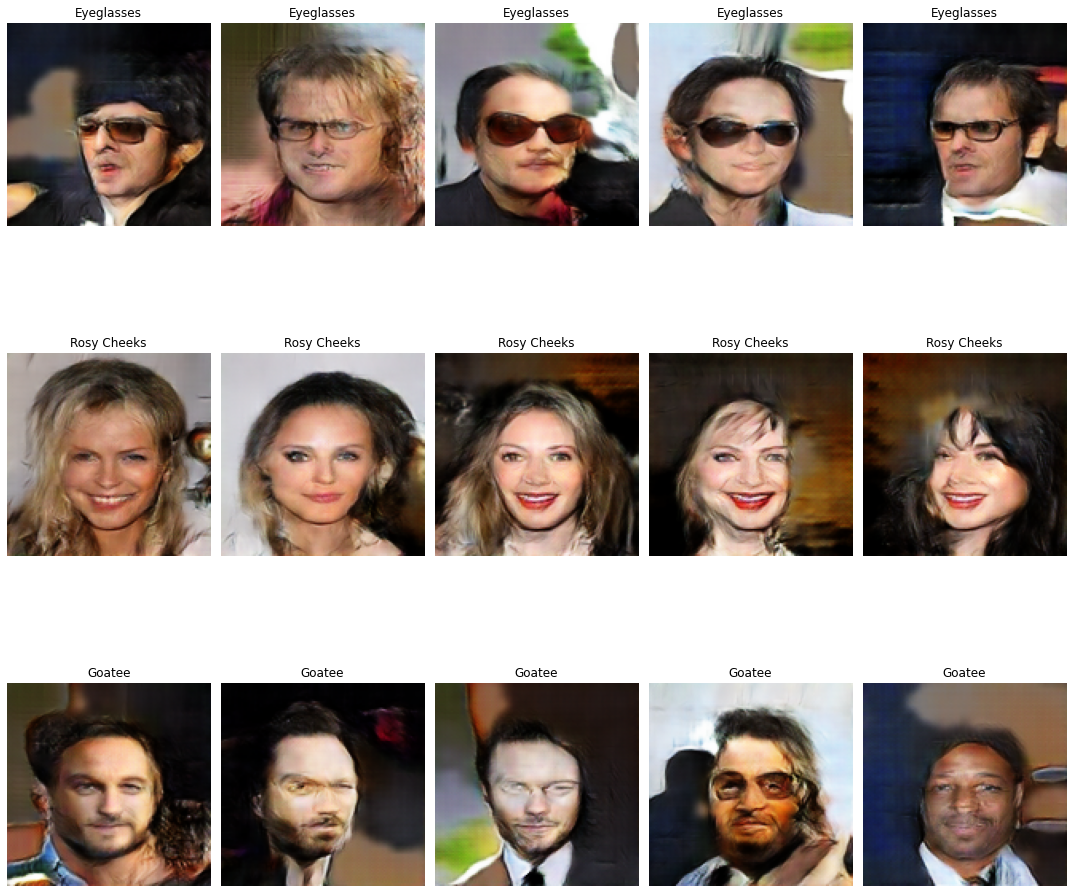

In [73]:
# Plot random images generated by a random latent vector. As you can see there is a wide variety of images generated (many modes). 
# The Rosy Cheeks attribute might generate very similiar pictures which we account to the fact that the training data was not as diverse as for the other classes
plot_fakes_complex(g_model, latent_dim)

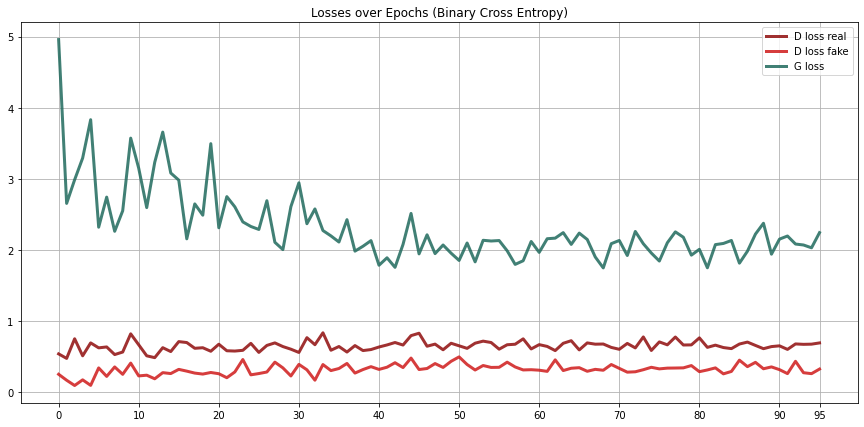

In [128]:
visualize_loss(FACEDATADIR+"/training_log/final_training.csv")

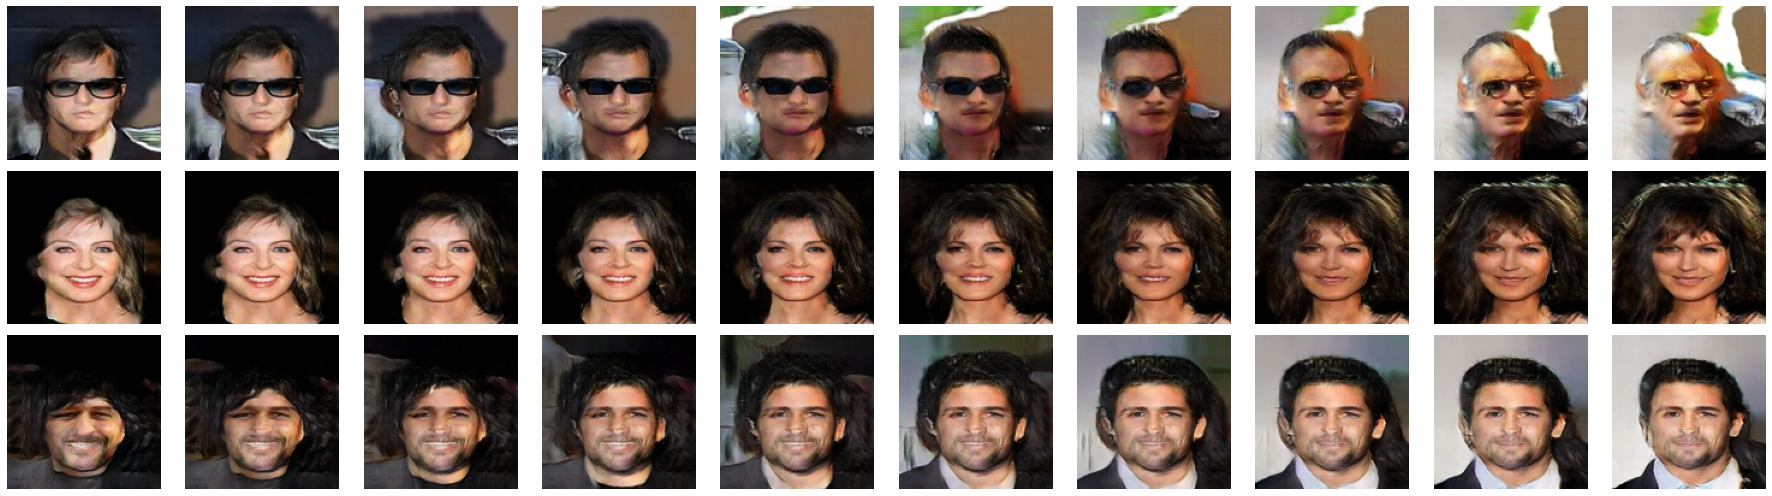

In [139]:
latent_interpolations(g_model)

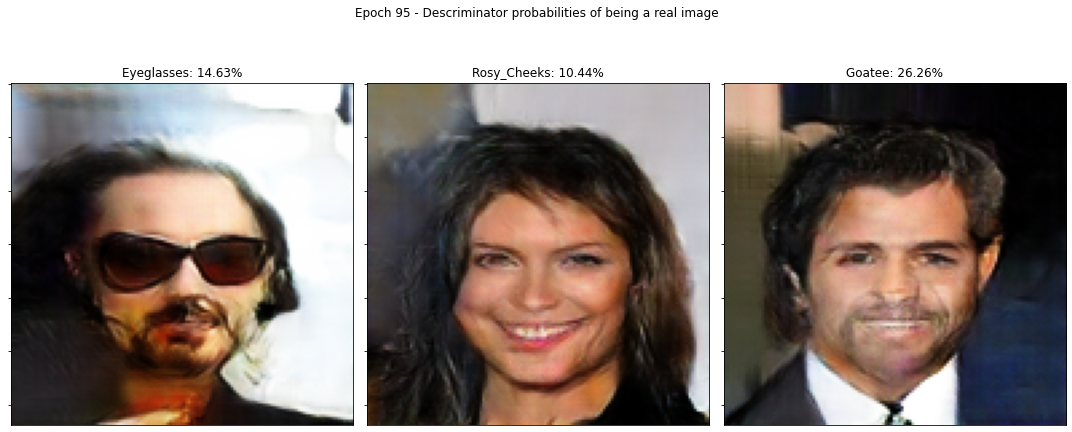

In [156]:
plot_random_with_discr(d_model, g_model, 95, latent_dim=100, class_header = ["Eyeglasses", "Rosy_Cheeks", "Goatee"])

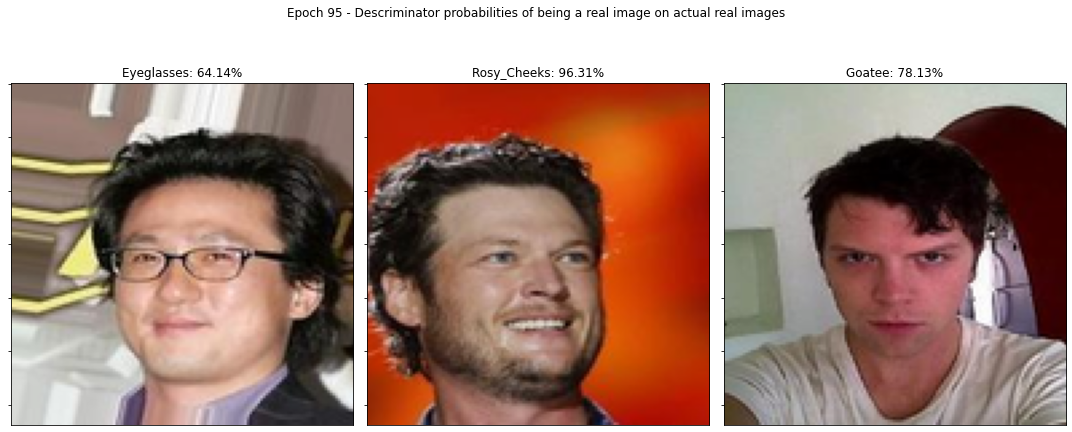

In [154]:
plot_real_with_discr(d_model,X,y, 95, latent_dim=100, class_header = ["Eyeglasses", "Rosy_Cheeks", "Goatee"])

## Results for the less_data model (190 epochs trained)

This model was trained on the full 40 classes as requested in the original task. Since we ran into memory issues we only took 750 instances per attribute for training. Although one can see what this model is trying to put out, one can also see that some representations are not learned. Generated Instances of class "Bald" are rarely really bald and many hair colors do not match.

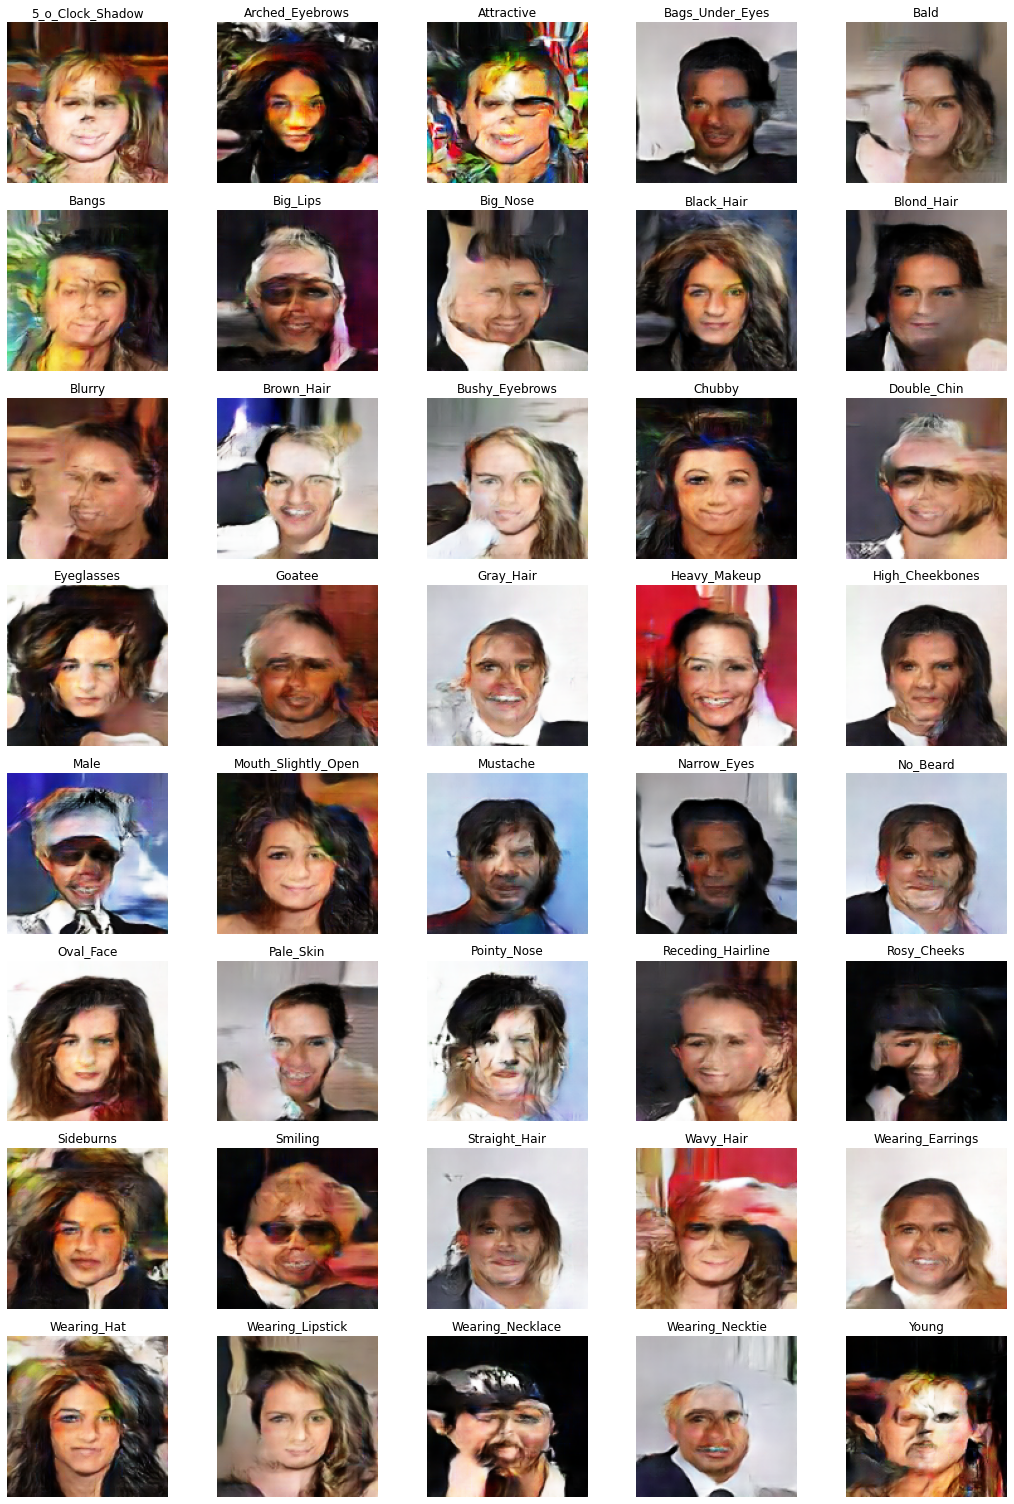

In [133]:
plot_fakes_shallow(g_model_40, latent_dim)

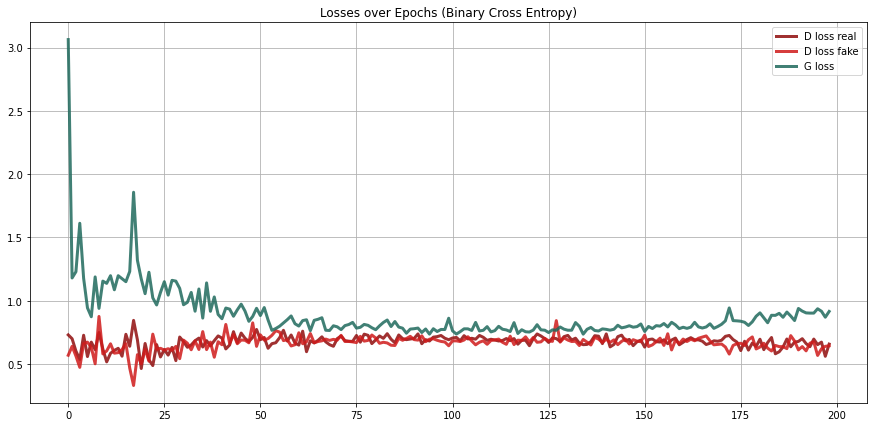

In [136]:
visualize_loss2(FACEDATADIR+"/training_log/lessd_training_full.csv")

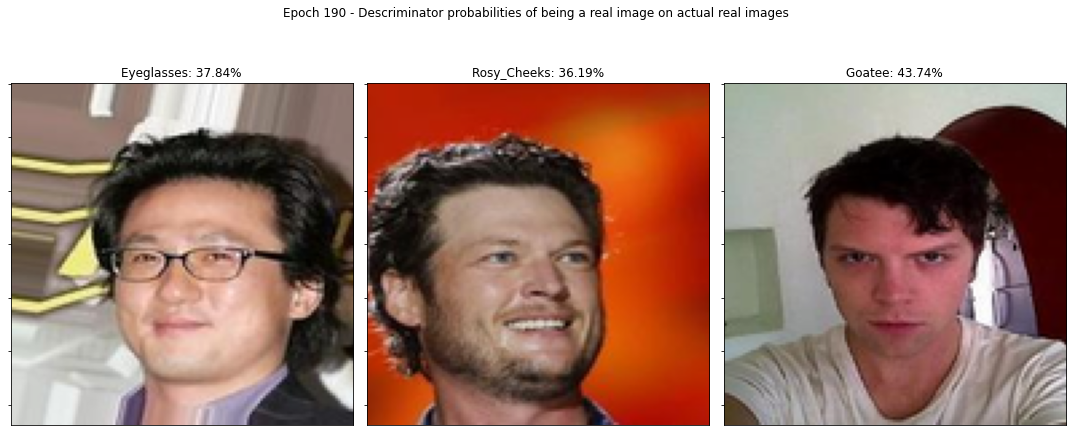

In [157]:
plot_real_with_discr(d_model_40,X,y, 190, latent_dim=100, class_header = ["Eyeglasses", "Rosy_Cheeks", "Goatee"])

Even after 190 Epochs, the discriminator does not detect the rather "easy" attribute of eyeglasses, which indicates underfitting. This could be because of the rather simple architecture or because of the little amount of data that was used for training. One could try to train on more data to find the cause of this underfitting.